In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import emcee
from iminuit import Minuit
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [3]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [4]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [8]:
data_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/fermi_data/"
# templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [9]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')

In [10]:
x_counts, y_counts, error_L, error_H, x_errors_L, x_errors_H = \
[np.array([  1.36887451e-10,   2.56502091e-10,   4.80638086e-10,
          9.00628020e-10,   1.68761248e-09,   3.16227766e-09,
          5.92553098e-09,   1.11033632e-08,   2.08056754e-08,
          3.89860370e-08,   7.30527154e-08]),
 np.array([  1.04000127e+08,   1.83397053e+08,   9.65856820e+07,
          1.51198295e+07,   4.76804443e+06,   9.78677656e+05,
          2.08916332e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 np.array([  2.14237668e+07,   2.08831658e+07,   1.10708578e+07,
          3.18362798e+06,   1.29929969e+06,   4.21069315e+05,
          1.34538182e+05,  -5.57461814e-04,  -2.97500603e-04,
         -1.58767124e-04,  -8.47292389e-05]),
 np.array([  2.63822671e+07,   2.34164673e+07,   1.24232945e+07,
          3.93887993e+06,   1.71404939e+06,   6.58746511e+05,
          2.74201404e+05,   1.02159419e+05,   5.45194091e+04,
          2.90953689e+04,   1.55273233e+04]),
 np.array([  3.68874510e-11,   6.91203483e-11,   1.29518913e-10,
          2.42694796e-10,   4.54765736e-10,   8.52147960e-10,
          1.59676969e-09,   2.99205487e-09,   5.60656455e-09,
          1.05056783e-08,   1.96857231e-08]),
 np.array([  5.04942913e-11,   9.46170829e-11,   1.77295138e-10,
          3.32218719e-10,   6.22517224e-10,   1.16648362e-09,
          2.18577733e-09,   4.09574765e-09,   7.67468330e-09,
          1.43809553e-08,   2.69472846e-08])]

In [11]:
GCE_options = [0,1]
GCE_tags = ["","_with_GCE_ps"]

In [12]:
Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')

In [13]:
xsecs_inj = [1e-26,1e-25,1e-24,1e-23]

In [14]:
templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [15]:
best_fit_norms = np.load(templates_dir+"best_fit_norms_band_2_ring_30.npy")
dif_bf = np.load(templates_dir+"dif_band_2_ring_30.npy")
iso_bf = np.load(templates_dir+"iso_band_2_ring_30.npy")
psc_bf = np.load(templates_dir+"psc_band_2_ring_30.npy")
bub_bf = np.load(templates_dir+"bub_band_2_ring_30.npy")
dsk_bf = np.load(templates_dir+"dsk_band_2_ring_30.npy")

In [16]:
best_fit_bkg = dif_bf+iso_bf+psc_bf+bub_bf+dsk_bf

In [17]:
def CDF(dxvals,pofx):
    yvals = pofx*dxvals
    sortxvals = np.argsort(yvals)
    yvals = yvals[sortxvals]
    return sortxvals,np.cumsum(yvals)

def PDFSample(xvals,sortxvals,cdf,samples):
    unidraw = np.random.uniform(high=cdf[-1], size=samples)
    cdfdraw = np.searchsorted(cdf, unidraw)
    cdfdraw = sortxvals[cdfdraw]
    return xvals[cdfdraw]

## Load scans

In [14]:
xsec_ind = 0
MC = 0
iGCE = 0

In [15]:
mchi = 100

particle = pa.Particle(channel='b', m_chi = mchi * GeV)

inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(xsecs_inj[xsec_ind]*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [107]:
MC_dir = "/tigress/ljchang/NPTF_test/data/injected_signal_MC/100GeV/"
data_file_path = MC_dir+"xbin_"+str(xsec_ind)+"_"+str(MC)+".npy"
data = np.load(data_file_path).astype(np.int32)
run_tag = "xbin_"+str(xsec_ind)+"_"+str(MC)+GCE_tags[iGCE]

In [108]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30,)

In [109]:
n = nptfit.NPTF(work_dir="../",tag=run_tag)
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [110]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                      ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                      [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                      [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                          ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                          [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                          [True,False,False,False,True,True])
if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                      [True,False,False,False,True,True])

In [111]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /tigress/ljchang/NPTF_test/Notebooks/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 18


In [112]:
n.load_scan()

  analysing data from ../chains/xbin_0_0/.txt


In [113]:
an = dnds_analysis.Analysis(n)

In [114]:
# an.make_triangle()
# plt.savefig('corner_'+run_tag+'.pdf')

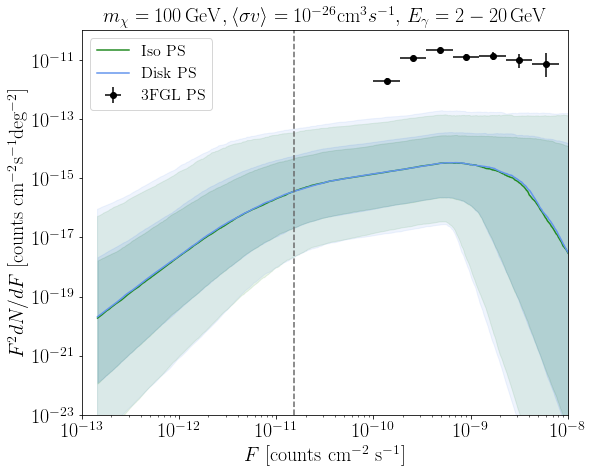

In [115]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
plt.ylim(1e-23,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
plt.savefig('plots/dNdF_'+run_tag+'.pdf')

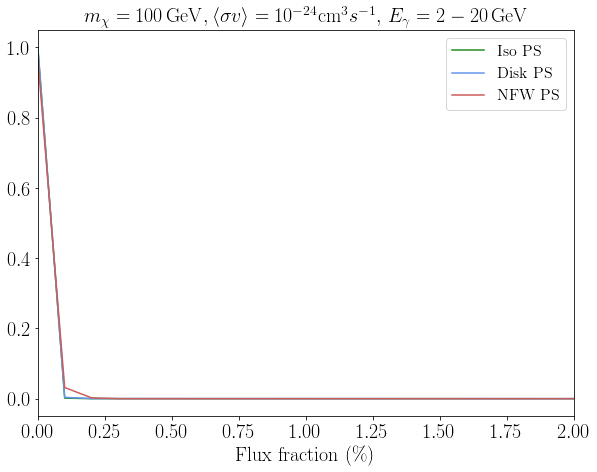

In [101]:
an.plot_intensity_fraction_non_poiss('iso_ps', bins=1000, color='forestgreen', label='Iso PS',qs=[])
an.plot_intensity_fraction_non_poiss('dsk_ps', bins=1000, color='cornflowerblue', label='Disk PS',qs=[])
if GCE_options[iGCE]:
    an.plot_intensity_fraction_non_poiss('nfw_ps', bins=1000, color='indianred', label='NFW PS',qs=[])

plt.legend(loc='upper right')
plt.xlim(0,2);
plt.xlabel(r'Flux fraction (\%)')
plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-24}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')

plt.tight_layout()
plt.savefig('plots/flux_fractions_nonpoiss_'+run_tag+'.pdf')

In [102]:
trueflux_dm = np.sum(~analysis_mask*inj_sig_map)/np.sum(~analysis_mask*((best_fit_bkg+inj_sig_map)))
trueflux_bubs = np.sum(~analysis_mask*bub_bf)/np.sum(~analysis_mask*((best_fit_bkg+inj_sig_map)))

In [103]:
trueflux_dm

0.44273220498456206

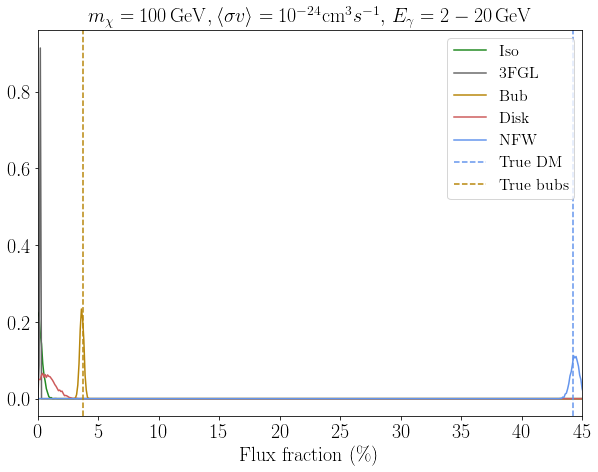

In [104]:
an.plot_intensity_fraction_poiss('iso', bins=1000, color='forestgreen', label='Iso',qs=[])
an.plot_intensity_fraction_poiss('psc', bins=1000, color='dimgray', label='3FGL',qs=[])
an.plot_intensity_fraction_poiss('bub', bins=1000, color='darkgoldenrod', label='Bub',qs=[])
an.plot_intensity_fraction_poiss('dsk', bins=1000, color='indianred', label='Disk',qs=[])
an.plot_intensity_fraction_poiss('nfw_dm', bins=1000, color='cornflowerblue', label='NFW',qs=[])

plt.axvline(trueflux_dm*100,ls='--',color='cornflowerblue',label='True DM')
plt.axvline(trueflux_bubs*100,ls='--',color='darkgoldenrod',label='True bubs')

plt.legend(loc='upper right')
plt.xlim(0,45);
plt.xlabel(r'Flux fraction (\%)')
plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-24}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')

plt.tight_layout()
plt.savefig('plots/flux_fractions_poiss_'+run_tag+'.pdf')

## Data scans

In [92]:
iGCE = 1

In [93]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30,)

In [94]:
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure

In [95]:
n = nptfit.NPTF(work_dir="../",tag="scan_data_gamma1p2"+GCE_tags[iGCE])
n.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [96]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                          [True,False,False,False,True,True])


pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 24


In [97]:
n.load_scan()

  analysing data from ../chains/scan_data_gamma1p2_with_GCE_ps/.txt


In [98]:
an = dnds_analysis.Analysis(n)

In [88]:
# an.make_triangle()

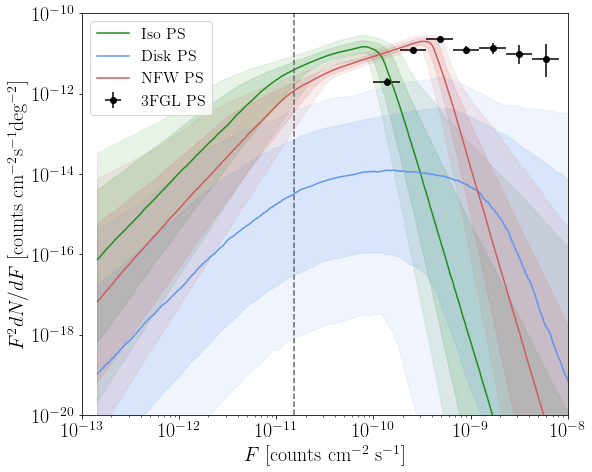

In [99]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
plt.savefig('plots/data/F2dNdF_IG_gamma1p2'+GCE_tags[iGCE]+'.pdf')

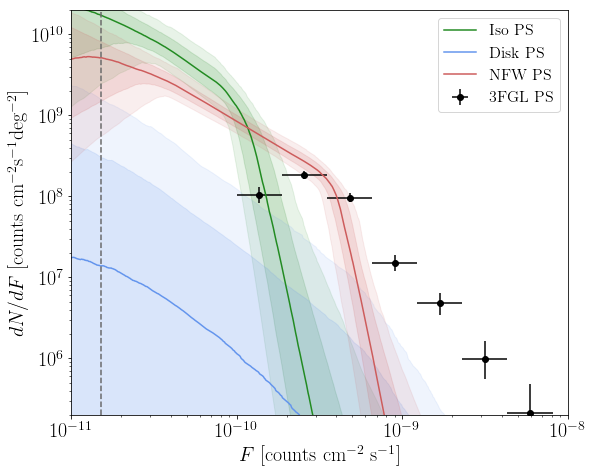

In [100]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-11,1e-8)
plt.ylim(2e5,2e10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
# plt.title('3FGL masked')
plt.tight_layout()
plt.savefig('plots/data/dNdF_IG_gamma1p2'+GCE_tags[iGCE]+'.pdf')

In [101]:
gce_flux = 7.714260456503495e-8

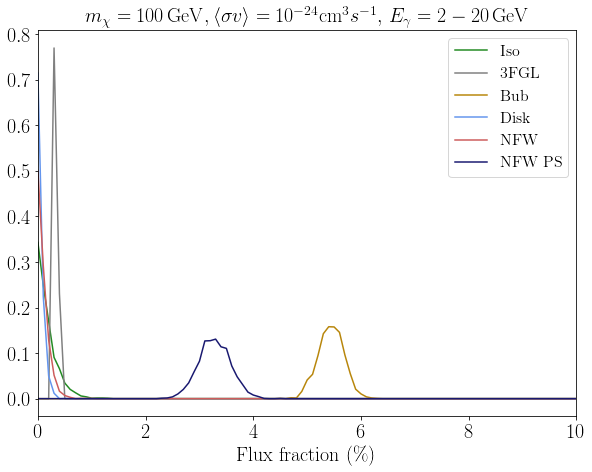

In [102]:
an.plot_intensity_fraction_poiss('iso', bins=1000, color='forestgreen', label='Iso',qs=[])
an.plot_intensity_fraction_poiss('psc', bins=1000, color='gray', label='3FGL',qs=[])
an.plot_intensity_fraction_poiss('bub', bins=1000, color='darkgoldenrod', label='Bub',qs=[])
an.plot_intensity_fraction_poiss('dsk', bins=1000, color='cornflowerblue', label='Disk',qs=[])
an.plot_intensity_fraction_poiss('nfw_dm', bins=1000, color='indianred', label='NFW',qs=[])
# plt.axvline(trueflux_dm*100,ls='--',color='indianred',label='True DM')
# plt.axvline(trueflux_ps*100,ls='--',color='midnightblue',label='True NFW PS')

if GCE_options[iGCE]:
    an.plot_intensity_fraction_non_poiss('nfw_ps',bins=1000, color='midnightblue', label='NFW PS',qs=[])
    
# plt.axvline(trueflux_dm*100,ls='--',color='cornflowerblue',label='True DM')
# plt.axvline(trueflux_bubs*100,ls='--',color='darkgoldenrod',label='True bubs')

plt.legend(loc='upper right')
plt.xlim(0,10);
plt.xlabel(r'Flux fraction (\%)')
plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-24}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')

plt.tight_layout()
plt.savefig('plots/data/fluxfracs_IG_gamma1p2'+GCE_tags[iGCE]+'.pdf')